In [3]:
import PIL
import numpy as np
from PIL import Image
from skimage import color

In [46]:
class Normalizer:
    def __init__(self):
        self.means = np.empty((0, 3))        
        self.stds = np.empty((0, 3))
        self.size = np.empty((0, 3))


    def fit(self, tile):
        tile_array = np.array(tile)
        lab = color.rgb2lab(tile_array)

        self.means = np.append(self.means, [[np.mean(lab[:,:,i]) for i in range(3)]], axis=0)
        self.stds = np.append(self.stds, [[np.std(lab[:,:,i]) for i in range(3)]], axis=0)
        self.size = np.append(self.size, [[lab[:, :, i].shape[0] * lab[:, :, i].shape[1] for i in range(3)]], axis=0)


    def fit_dir(self, current_path):
        for filename in os.listdir(current_path):
            if filename != "rejected":
                new_path = os.path.join(current_path, filename)
                if os.path.isfile(new_path):
                    tile = Image.open(new_path)
                    tile = self.fit(tile)
                else:
                    self.fit_dir(new_path)



    def normalize(self, tile):
        """
        sig = sum[ (n_i - 1)sig_i + n_i(y_bar_i - y_bar)^2 ]/ sum[ n_i ]-1
        """
        
        total_n = np.sum(self.size, axis=0)
        weighted_avg = np.sum(np.multiply(self.size, self.means), axis=0)/ total_n
        
        sig_2 = np.sum(np.multiply(self.size-1, self.stds) + np.multiply(self.size, (self.means - weighted_avg)**2), axis=0)/total_n
        
        sig = np.sqrt(sig_2)

        mu = np.mean(self.means, axis=0)
#         avg_stds = np.mean(self.stds, axis=0)

        tile_array = np.array(tile)
        lab = color.rgb2lab(tile_array)

        t_mean = [0,0,0]
        t_std  = [1,1,1]

        # Each channel 
        for i in range(3):
            t_mean[i] = np.mean(lab[:,:,i])
            t_std[i]  = np.std(lab[:,:,i])
            tmp = ( (lab[:,:,i] - t_mean[i]) * (sig[i] / t_std[i]) ) + mu[i]
            if i == 0:
                tmp[tmp<0] = 0
                tmp[tmp>100] = 100
                lab[:,:,i] = tmp
            else:
                tmp[tmp<-127] = -127
                tmp[tmp>127] = 127
                lab[:,:,i] = tmp

        return Image.fromarray((color.lab2rgb(lab)*255).astype(np.uint8))


    def normalize_dir(self, current_path):
        for filename in os.listdir(current_path):
            if filename != "rejected":
                new_path = os.path.join(current_path, filename)
                if os.path.isfile(new_path):
                    tile = Image.open(new_path)
                    tile = self.normalize(tile)
                    tile.save(new_path)
                else:
                    self.normalize_dir(new_path)

In [52]:
regular_tile = Image.open("img/normalization/regular_tile.jpeg")
normalized_tile = Image.open("img/normalization/normalized_tile.jpeg")

999

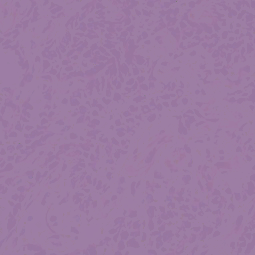

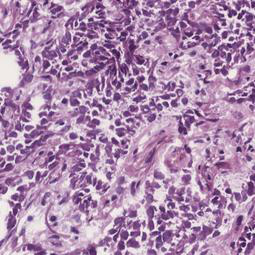

In [55]:
normalizer = Normalizer()

for i in range(5000):
    print(f"\r{i}", end="")
    normalizer.fit(regular_tile)

    regular_tile = normalizer.normalize(regular_tile)

display(regular_tile)
display(normalized_tile)

Regular


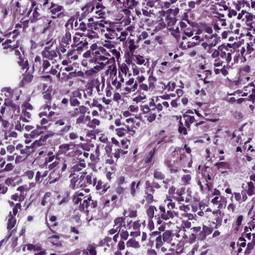

In [4]:
print("Regular")
display(regular_tile)

Nomalized


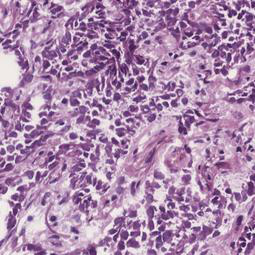

In [5]:
print("Nomalized")
display(normalized_tile)

Diff


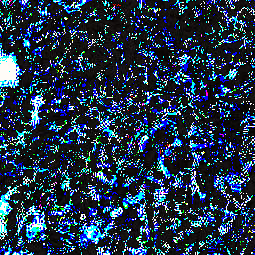

In [6]:
reg_np = np.array(regular_tile)
norm_np = np.array(normalized_tile)

diff_np = norm_np - reg_np
diff = Image.fromarray(diff_np)

print("Diff")
display(diff)